<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks/Netflix_Problem_Matrix_completion_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_seed(seed=123):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)          # 单个 GPU
    torch.cuda.manual_seed_all(seed)      # 多 GPU 情况

    torch.backends.cudnn.deterministic = True  # 保证可重复性
    torch.backends.cudnn.benchmark = False     # 禁用自动算法优化

set_seed(123)

In [ ]:
ratings_list = [i.strip().split("::") for i in open('/content/ratings.dat', 'r').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns=['UserID', 'MovieID', 'Rating', 'Timestamp']).astype(int)

ratings = ratings_df[['UserID', 'MovieID', 'Rating']]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

user_tensor = torch.tensor(ratings['UserID'].values, dtype=torch.long, device=device)
movie_tensor = torch.tensor(ratings['MovieID'].values, dtype=torch.long, device=device)
rating_tensor = torch.tensor(ratings['Rating'].values, dtype=torch.float32, device=device)

In [ ]:
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating')
user_ids = sorted(ratings_df['UserID'].unique())
movie_ids = sorted(ratings_df['MovieID'].unique())

In [ ]:
R = R_df.values
user_ratings_mean = np.nanmean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
R_demeaned
#

array([[ 0.81132075,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.57771261,         nan,         nan, ...,         nan,
                nan,         nan]])

In [ ]:
TR_demeaned = torch.tensor(R_demeaned, dtype=torch.float32, device='cuda')
TR = torch.tensor(R, dtype=torch.float32, device='cuda')

<ipython-input-21-9d103b87e7f6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TR = torch.tensor(R, dtype=torch.float32, device='cuda')


In [ ]:
class MF_Adam(nn.Module):
    def __init__(self,  X_train, train_mask, k):
        super().__init__()
        self.device = X_train.device
        self.X = X_train
        self.k = k

        self.m, self.n = X_train.shape

        # Create observation mask
        self.mask = train_mask
        scale = 1.0 / math.sqrt(k)

        # Latent factors
        self.U = nn.Parameter(torch.randn(self.m, k, device=self.device) * 0.02)
        self.V = nn.Parameter(torch.randn(self.n, k, device=self.device) *0.02)

        # Bias terms
        self.b_u = nn.Parameter(torch.zeros(self.m, device=self.device))
        self.b_v = nn.Parameter(torch.zeros(self.n, device=self.device))

        # Global bias
        mean_value = torch.nanmean(X_train).item()
        self.b = nn.Parameter(torch.tensor(mean_value, dtype=torch.float32, device=self.device))


    def forward(self):
        pred = self.b + self.b_u[:, None] + self.b_v[None, :] + self.U @ self.V.T
        return pred


    def train_loss(self, loss_type="mse", l2_lambda=1e-4, huber_delta=1.0):
          """
          Computes masked loss + optional L2 regularization.

          Parameters:
              loss_type (str): "mse", "mae", or "huber"
              l2_lambda (float): L2 regularization weight (default=1e-4)
              huber_delta (float): delta for Huber loss (default=1.0)

          Returns:
              torch scalar loss
          """
          pred = self.forward()
          true = self.X[self.mask]
          pred = pred[self.mask]

          if loss_type == "mse":
              loss = F.mse_loss(pred, true)
          elif loss_type == "mae":
              loss = F.l1_loss(pred, true)
          elif loss_type == "huber":
              loss = F.huber_loss(pred, true, delta=huber_delta)
          else:
              raise ValueError(f"Unsupported loss type: {loss_type}")

          # L2 regularization
          reg = l2_lambda * (self.U.norm() ** 2 + self.V.norm() ** 2)

          return loss + reg


    def full_matrix(self):
        return self.forward().detach()

    def replace_pred(self, pred_matrix):
        X_copy = self.X.clone().detach()
        X_copy[~self.mask] = pred_matrix[~self.mask]
        return X_copy


In [ ]:
def create_train_test_split(X, num_test=2500, seed=123):
    observed_idx = torch.nonzero(~torch.isnan(X), as_tuple=False)
    perm = torch.randperm(observed_idx.size(0), generator=torch.Generator().manual_seed(seed))
    test_idx = observed_idx[perm[:num_test]]

    # 生成训练数据：把测试评分设置为 NaN（注意：不能设为 0）
    X_train = X.clone()
    X_train[test_idx[:, 0], test_idx[:, 1]] = float('nan')

    # 提取测试集真实评分
    train_mask = ~torch.isnan(X_train) # True where value is observed
    test_ratings = X[test_idx[:, 0], test_idx[:, 1]]

    return X_train, train_mask, test_idx, test_ratings

In [ ]:
def plot_history(history):
    import numpy as np
    history = np.array(history)
    epochs = history[:, 0]
    train_loss = history[:, 1]
    test_rmse = history[:, 2]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Train Loss (MSE)", marker='o')
    plt.plot(epochs, test_rmse, label="Test RMSE", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss / RMSE")
    plt.title("Training Loss & Test RMSE over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def train_and_evaluate(X_train, train_mask, test_idx, test_ratings,
                       k=5, epochs=200, lr=1e-3, wd=1e-4,
                       loss_type="mse", l2_lambda=1e-4,
                       verbose=True, plot=False,
                       save_model_path=None):
    """
    Trains MF_Adam on training data and evaluates on test set.

    Parameters:
        X_train (torch.Tensor): Training rating matrix (test positions = NaN)
        train_mask (torch.BoolTensor): True where training values are known
        test_idx (LongTensor): N x 2 tensor of (i, j) test positions
        test_ratings (FloatTensor): Ground truth ratings at test positions
        k (int): Latent dimension
        epochs (int): Training epochs
        lr (float): Learning rate
        wd (float): Weight decay
        verbose (bool): Whether to print progress

    Returns:
        history (list): List of (epoch, train_loss, test_rmse)
        X_hat (tensor): Final completed rating matrix
    """
    device = X_train.device
    model = MF_Adam(X_train, train_mask, k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    history = []

    best_rmse = float("inf")
    best_epoch = 0
    patience = 10
    min_delta = 1e-5
    early_stop = False

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Train loss on masked observed entries
        train_loss = model.train_loss(loss_type=loss_type, l2_lambda=l2_lambda)
        train_loss.backward()
        optimizer.step()

        # Evaluation (no grad)
        model.eval()
        with torch.no_grad():
            pred_matrix = model.forward()
            test_preds = pred_matrix[test_idx[:, 0], test_idx[:, 1]]
            test_rmse = F.mse_loss(test_preds, test_ratings).sqrt().item()

        history.append((epoch, train_loss.item(), test_rmse))

        if verbose and ((epoch+1) % 10 == 0 ):
            print(f"Epoch {epoch + 1} | Train Loss: {train_loss.item():.6f} | Test RMSE: {test_rmse:.6f}")

        if test_rmse + min_delta < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch
            best_weights = model.state_dict()  # 保存权重
        else:
            if epoch - best_epoch >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best RMSE: {best_rmse:.6f} at epoch {best_epoch + 1}")
                early_stop = True
                break

    model.load_state_dict(best_weights)
    X_hat = model.full_matrix()

    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"✅ Model saved to: {save_model_path}")

    if plot:
        plot_history(history)

    print(f"\n Training completed. Best Test RMSE: {best_rmse:.6f} at epoch {best_epoch + 1}.")


    return history, X_hat, best_rmse, best_epoch



Epoch 10 | Train Loss: 1.051558 | Test RMSE: 1.016820
Epoch 20 | Train Loss: 1.044058 | Test RMSE: 1.013795
Epoch 30 | Train Loss: 1.035668 | Test RMSE: 1.009676
Epoch 40 | Train Loss: 1.024770 | Test RMSE: 1.004164
Epoch 50 | Train Loss: 1.010392 | Test RMSE: 0.996811
Epoch 60 | Train Loss: 0.992679 | Test RMSE: 0.987639
Epoch 70 | Train Loss: 0.972726 | Test RMSE: 0.977151
Epoch 80 | Train Loss: 0.952130 | Test RMSE: 0.966179
Epoch 90 | Train Loss: 0.932451 | Test RMSE: 0.955599
Epoch 100 | Train Loss: 0.914824 | Test RMSE: 0.946059
Epoch 110 | Train Loss: 0.899821 | Test RMSE: 0.937883
Epoch 120 | Train Loss: 0.887528 | Test RMSE: 0.931144
Epoch 130 | Train Loss: 0.877709 | Test RMSE: 0.925771
Epoch 140 | Train Loss: 0.869976 | Test RMSE: 0.921589
Epoch 150 | Train Loss: 0.863915 | Test RMSE: 0.918367
Epoch 160 | Train Loss: 0.859147 | Test RMSE: 0.915875
Epoch 170 | Train Loss: 0.855360 | Test RMSE: 0.913920
Epoch 180 | Train Loss: 0.852299 | Test RMSE: 0.912355
Epoch 190 | Train L

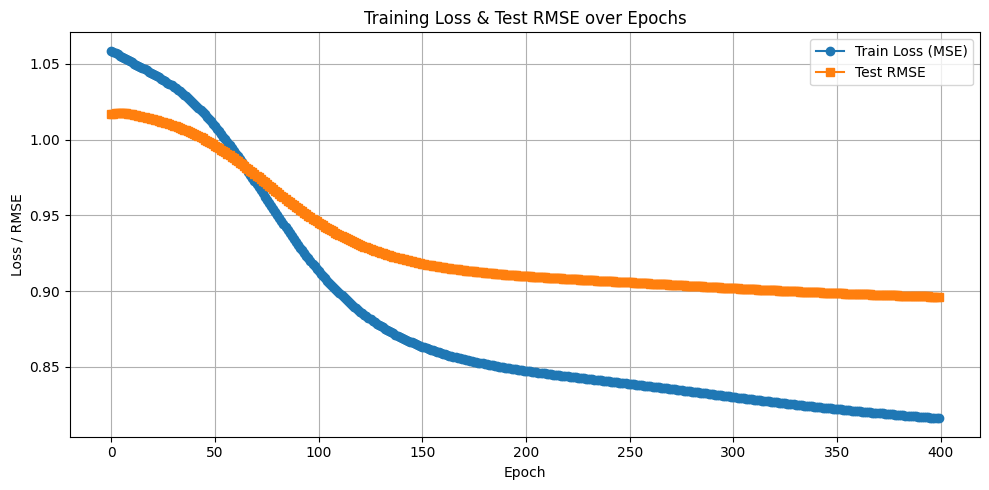


 Training completed. Best Test RMSE: 0.896233 at epoch 400.


In [ ]:
X_train, train_mask, test_idx, test_ratings = create_train_test_split(TR)

history, X_hat, best_rmse, best_epoch = train_and_evaluate(
    X_train, train_mask, test_idx, test_ratings,
    k=20, epochs=400, loss_type="mse", l2_lambda=1e-5,
    plot=True
)

In [ ]:
def run_grid_search(X_train, train_mask, test_idx, test_ratings,
                    k_list=[10, 20, 30],
                    l2_list=[1e-4, 5e-4, 1e-3],
                    loss_types=["mse", "huber"],
                    lr_list=[5e-4, 1e-3, 2e-3],
                    epochs=100,
                    plot_best=True,
                    verbose=False):
    """
    Grid search over MF_Adam hyperparameters.

    Parameters:
        X_train, train_mask, test_idx, test_ratings: training/test data tensors
        k_list: latent dimension values
        l2_list: L2 regularization values
        loss_types: loss function names
        lr_list: learning rates
        epochs: training epochs per run
        plot_best: whether to plot training curve for best model
        verbose: whether to print all training logs

    Returns:
        results_df: pandas DataFrame of results
    """
    results = []
    best_rmse_overall = float("inf")
    best_history = None

    total_runs = len(k_list) * len(l2_list) * len(loss_types) * len(lr_list)
    run_counter = 0

    for lr in lr_list:
        for k in k_list:
            for l2 in l2_list:
                for loss_type in loss_types:
                    run_counter += 1
                    print(f"\n🔍 [{run_counter}/{total_runs}] Training: "
                          f"k={k}, λ={l2}, loss={loss_type}, lr={lr}")

                    history, X_hat, best_rmse, best_epoch = train_and_evaluate(
                        X_train, train_mask, test_idx, test_ratings,
                        k=k, epochs=epochs, lr=lr,
                        loss_type=loss_type, l2_lambda=l2,
                        plot=False, verbose=verbose
                    )

                    results.append({
                        "k": k,
                        "l2_lambda": l2,
                        "loss_type": loss_type,
                        "lr": lr,
                        "best_rmse": round(best_rmse, 6),
                        "best_epoch": best_epoch + 1
                    })

                    if plot_best and best_rmse < best_rmse_overall:
                        best_rmse_overall = best_rmse
                        best_history = history

    results_df = pd.DataFrame(results).sort_values(by="best_rmse").reset_index(drop=True)

    print("\n🏁 Grid search complete. Top 5 results:\n")
    print(results_df.head(5).to_string(index=False))

    if plot_best and best_history is not None:
        plot_history(best_history)

    return results_df


🔍 [1/54] Training: k=20, λ=0.0001, loss=mse, lr=0.001

 Training completed. Best Test RMSE: 0.938786 at epoch 300.

🔍 [2/54] Training: k=20, λ=0.0001, loss=huber, lr=0.001

 Training completed. Best Test RMSE: 0.952277 at epoch 300.

🔍 [3/54] Training: k=20, λ=0.0005, loss=mse, lr=0.001

 Training completed. Best Test RMSE: 0.951065 at epoch 300.

🔍 [4/54] Training: k=20, λ=0.0005, loss=huber, lr=0.001

 Training completed. Best Test RMSE: 0.952277 at epoch 300.

🔍 [5/54] Training: k=20, λ=0.001, loss=mse, lr=0.001

 Training completed. Best Test RMSE: 0.951064 at epoch 300.

🔍 [6/54] Training: k=20, λ=0.001, loss=huber, lr=0.001

 Training completed. Best Test RMSE: 0.952277 at epoch 300.

🔍 [7/54] Training: k=30, λ=0.0001, loss=mse, lr=0.001

 Training completed. Best Test RMSE: 0.938853 at epoch 300.

🔍 [8/54] Training: k=30, λ=0.0001, loss=huber, lr=0.001

 Training completed. Best Test RMSE: 0.952277 at epoch 300.

🔍 [9/54] Training: k=30, λ=0.0005, loss=mse, lr=0.001

 Training 

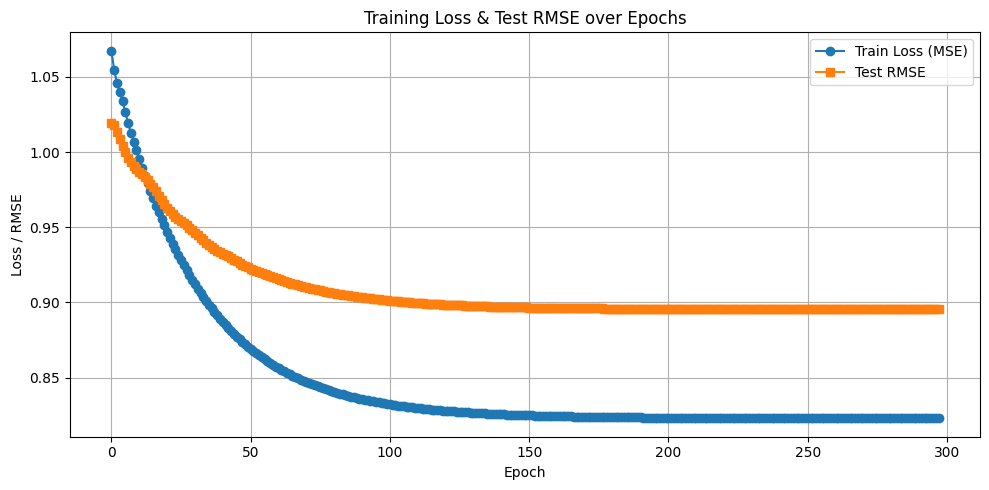

In [ ]:
k_list = [20, 30, 50]
l2_list = [1e-4, 5e-4, 1e-3]
loss_types = ["mse","huber"]
lr_list = [1e-3, 5e-3, 1e-2]

results_df = run_grid_search(
    X_train, train_mask, test_idx, test_ratings,
    k_list=k_list,
    l2_list=l2_list,
    loss_types=loss_types,
    lr_list=lr_list,
    epochs=300,
    plot_best=True,
    verbose=False
)

Epoch 10 | Train Loss: 1.007466 | Test RMSE: 0.989047
Epoch 20 | Train Loss: 0.952901 | Test RMSE: 0.965232
Epoch 30 | Train Loss: 0.915669 | Test RMSE: 0.947906
Epoch 40 | Train Loss: 0.889355 | Test RMSE: 0.933718
Epoch 50 | Train Loss: 0.870682 | Test RMSE: 0.923415
Epoch 60 | Train Loss: 0.857371 | Test RMSE: 0.915939
Epoch 70 | Train Loss: 0.847844 | Test RMSE: 0.910482
Epoch 80 | Train Loss: 0.841004 | Test RMSE: 0.906517
Epoch 90 | Train Loss: 0.836072 | Test RMSE: 0.903582
Epoch 100 | Train Loss: 0.832504 | Test RMSE: 0.901392
Epoch 110 | Train Loss: 0.829914 | Test RMSE: 0.899780
Epoch 120 | Train Loss: 0.828031 | Test RMSE: 0.898603
Epoch 130 | Train Loss: 0.826658 | Test RMSE: 0.897740
Epoch 140 | Train Loss: 0.825655 | Test RMSE: 0.897110
Epoch 150 | Train Loss: 0.824919 | Test RMSE: 0.896653
Epoch 160 | Train Loss: 0.824378 | Test RMSE: 0.896326
Epoch 170 | Train Loss: 0.823979 | Test RMSE: 0.896090
Epoch 180 | Train Loss: 0.823685 | Test RMSE: 0.895921
Epoch 190 | Train L

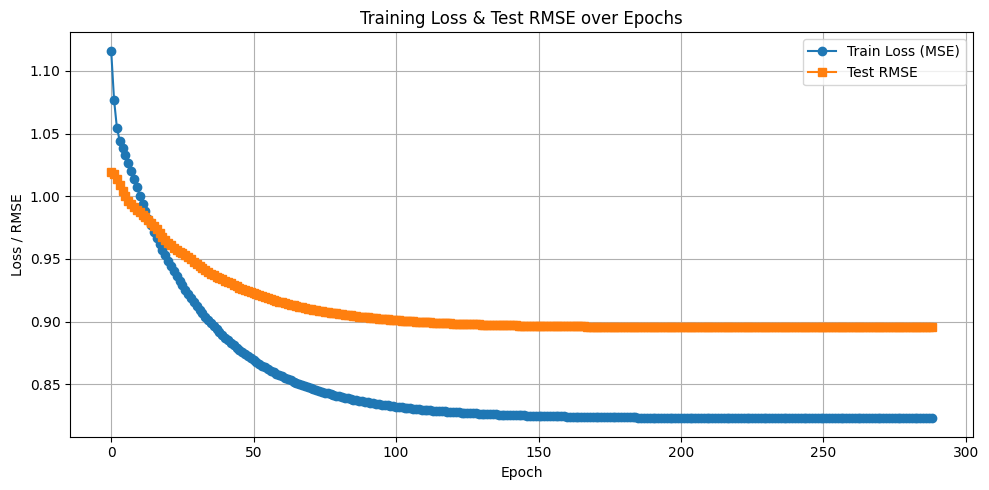


 Training completed. Best Test RMSE: 0.895482 at epoch 279.


In [ ]:
best_model_path = "/content/drive/MyDrive/mf_best_model.pth"

history, X_hat, best_rmse, best_epoch = train_and_evaluate(
    X_train, train_mask, test_idx, test_ratings,
    k=30, epochs=300, lr=0.01,
    loss_type="mse", l2_lambda=5e-4,
    plot=True,
    save_model_path=best_model_path
)


In [ ]:
X_hat_np = X_hat.cpu().numpy()
df_hat = pd.DataFrame(X_hat_np, index=user_ids, columns=movie_ids)
# df_hat.to_csv("/content/drive/MyDrive/Film_Rating_filled.csv")

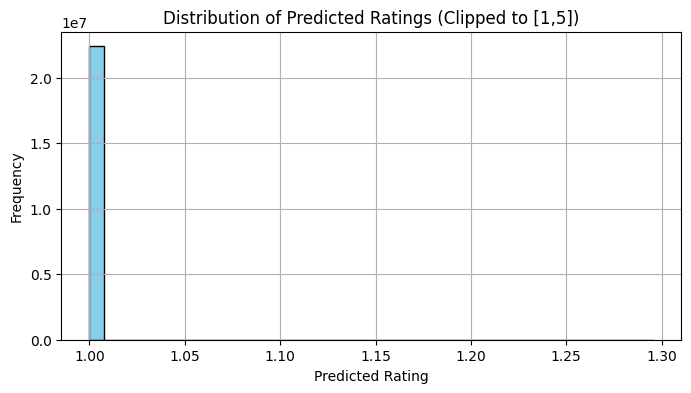

In [ ]:
X_hat_clip = torch.clamp(X_hat, min=1.0, max=5.0)

# 转为 numpy
all_preds = X_hat_clip.cpu().numpy().flatten()

plt.figure(figsize=(8, 4))
plt.hist(all_preds, bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of Predicted Ratings (Clipped to [1,5])")
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()